# Find precipitation value for pulsed and upslope storms

In [1]:
import numpy as np
import netCDF4
import pandas as pd
import matplotlib.pyplot as plt


np.warnings.filterwarnings('ignore')



In [2]:
m = ['11', '12', '01', '02', '03']
station = 'Haukeliseter'

### Minuelty data

In [3]:
obs_f = dict()
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m   = dict()
obs_wind_speed_10m = dict()
obs_dofe_acc   = dict()
obs_wind_dir   = dict()
obs_wind_speed = dict() 
obs_dofe_acc_rolling = dict()
obs_wind_dir_rolling = dict()
obs_wind_speed_rolling = dict()
obs_diff = dict()
obs_westerly_idx = dict()
obs_easterly_idx = dict()
obs_westerly = dict()
obs_easterly = dict()
obs_total_precip = dict()
obs_precip_west  = dict()
obs_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(7,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        obs_dirnc = '../../Data/Weathermast/Met_%s%s%s_%s.nc' %(year,month,day,station)
        obs_f[int(year+month+day)] = netCDF4.Dataset(obs_dirnc, 'r')

        obs_double_fence_acc_mean[int(year+month+day)] = (np.nanmean(obs_f[int(year+month+day)].variables['double_fence_accum'][:], axis=1))
        obs_wind_dir_10m[int(year+month+day)]   = (obs_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
        obs_wind_speed_10m[int(year+month+day)] = (obs_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        obs_f[int(year+month+day)].close
        
        ## Create a rolling mean to smoothen out the data
        # attach the last 9 minutes from the previous day to calculate the rolling mean every 10 minutes
        if month != '11' and day == '01':
            if month == '12':
                previous_day = '30'
            elif month == '01' or month == '02':
                previous_day = '31'
            elif month == '03':
                previous_day = '28'
            if month == '01':
                previous_month = '12'
                previous_year = str(int(year)-1)
            elif month == '12':
                previous_month = str(int(month)-1)
                previous_year = year
            else:
                previous_month = '0%s' %(int(month)-1)
                previous_year = year
            
        elif int(day)-1 < 10:
            previous_day = '0%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        else:
            previous_day = '%s' %(int(day)-1)
            previous_month = month
            previous_year = year
        if year == '2016' and month == '11' and day == '07':
            continue
        else:
            pp = (np.concatenate((obs_double_fence_acc_mean[int(previous_year+previous_month+previous_day)][-9:],
                                  obs_double_fence_acc_mean[int(year+month+day)][:])))
            obs_dofe_acc[int(year+month+day)] = (pp)
            wd = (np.concatenate((obs_wind_dir_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_dir_10m[int(year+month+day)][:])))
            obs_wind_dir[int(year+month+day)] = (wd)
            ws = (np.concatenate((obs_wind_speed_10m[int(previous_year+previous_month+previous_day)][-9:], 
                                  obs_wind_speed_10m[int(year+month+day)][:])))
            obs_wind_speed[int(year+month+day)] = (ws)
        # Calculate the moving average. That is, take
        # the first ten values, average them, 
        # then drop the first and add the eleventh, etc.
        obs_dofe_acc[int(year+month+day)] = pd.DataFrame(np.array(obs_dofe_acc[int(year+month+day)])[:])
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc[int(year+month+day)].rolling(window=10,
                                                                                              min_periods= 7,
                                                                                              axis=0).mean()
        obs_dofe_acc_rolling[int(year+month+day)] = obs_dofe_acc_rolling[int(year+month+day)].values
        obs_dofe_acc_rolling[int(year+month+day)] = np.array(obs_dofe_acc_rolling[int(year+month+day)])[9:,:]

        obs_wind_dir[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_dir[int(year+month+day)])[:])
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir[int(year+month+day)].rolling(window=10,
                                                                                              min_periods=7,
                                                                                              axis=0).mean()
        obs_wind_dir_rolling[int(year+month+day)] = obs_wind_dir_rolling[int(year+month+day)].values
        obs_wind_dir_rolling[int(year+month+day)] = np.array(obs_wind_dir_rolling[int(year+month+day)])[9:,:]

        obs_wind_speed[int(year+month+day)] = pd.DataFrame(np.array(obs_wind_speed[int(year+month+day)])[:])
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed[int(year+month+day)].rolling(window=10,
                                                                                                  min_periods=7,
                                                                                                  axis=0).mean()
        obs_wind_speed_rolling[int(year+month+day)] = obs_wind_speed_rolling[int(year+month+day)].values
        obs_wind_speed_rolling[int(year+month+day)] = np.array(obs_wind_speed_rolling[int(year+month+day)])[9:,:]
        
        
        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[int(year+month+day)] = np.empty(shape=(obs_dofe_acc_rolling[int(year+month+day)].shape))#/60))
        obs_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,obs_dofe_acc_rolling[int(year+month+day)].shape[0]-1):#/60):
            obs_diff[int(year+month+day)][int(i),:] = obs_dofe_acc_rolling[int(year+month+day)][int(i)+1] - \
                                                      obs_dofe_acc_rolling[int(year+month+day)][int(i)]


        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0])

        ## find all obs_westerly regimes (202.5 - 22.5 deg) 
        obs_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 202.5), 
                                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <= 360)),
                                                              (obs_wind_dir_rolling[int(year+month+day)][:,0] <22.5))]
        ## find all obs_easterly regimes (22.5 - 202.5 deg)
        obs_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((obs_wind_dir_rolling[int(year+month+day)][:,0] >= 22.5),
                                                                (obs_wind_dir_rolling[int(year+month+day)][:,0] < 202.5))]

        ## find indices for all obs_westerly regimes 
        sub_idx = []

        for i in range(0,obs_westerly_idx[int(year+month+day)] .shape[0]-1):
            if obs_westerly_idx[int(year+month+day)] [i]+1 == obs_westerly_idx[int(year+month+day)] [i+1]:
                continue
            else:
                #print(i)
                sub_idx.append(i)
    
    #        print([int(year+month+day)], obs_westerly_idx[int(year+month+day)], sub_idx)
        
        
        ## find westerlies which are < 29 min and assign them to obs_easterly wind regime
        if len(obs_westerly_idx[int(year+month+day)]) == 0 and len(sub_idx) == 0:     # westerlies do not exist
            obs_westerly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
#            print('No obs_westerly wind on %s' %(int(year+month+day)))
        elif len(obs_westerly_idx[int(year+month+day)]) != 0 and len(sub_idx) == 0:   # westerlies exist only for one time period a day
            obs_westerly[int(year+month+day)] = []
      #      obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]
            
            obs_westerly_duration = obs_westerly_idx[int(year+month+day)][-1] - obs_westerly_idx[int(year+month+day)][0]
            if obs_westerly_duration >= 28:
                obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
            elif obs_westerly_duration < 28:
                obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                obs_westerly_idx[int(year+month+day)][:]))
        else:
            obs_westerly[int(year+month+day)] = []
         #   obs_easterly[int(year+month+day)] = []
            obs_easterly[int(year+month+day)] = obs_easterly_idx[int(year+month+day)]

            for i in np.arange(0,np.array(sub_idx).shape[0]+1):                # westerlies and easterlies interchange daily
                if i == 0:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[0]] - \
                                         obs_westerly_idx[int(year+month+day)] [0])
                elif i == np.array(sub_idx).shape[0]:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [-1] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1])
                else:
                    obs_westerly_duration = (obs_westerly_idx[int(year+month+day)] [ sub_idx[i]] - \
                                         obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1])
                if obs_westerly_duration >= 28:
                    if i == 0:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
            #            print(obs_westerly_duration, RR_obs_westerly)
                    elif i == np.array(sub_idx).shape[0]:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
             #           print(obs_westerly_duration, RR_obs_westerly)
                    else:
                        obs_westerly[int(year+month+day)] = np.concatenate((obs_westerly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
              #          print(obs_westerly_duration, RR_obs_westerly)
                elif obs_westerly_duration < 28:
                    if i == 0:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)], 
                                                                        obs_westerly_idx[int(year+month+day)] [ 0: sub_idx[0]+1]))
                    elif i == np.array(sub_idx).shape[0]:
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[np.array(sub_idx).shape[0]-1]+1 : ]))
                    else:
                   # print(obs_westerly_duration)
                        obs_easterly[int(year+month+day)] = np.concatenate((obs_easterly[int(year+month+day)],
                                                                        obs_westerly_idx[int(year+month+day)] [ sub_idx[i-1]+1 : sub_idx[i]+1]))
        

        if len(obs_westerly[int(year+month+day)]) == 0:    # only easterlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                  'obs_easterly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
                  'obs_westerly [mm/24h]:', 
                  np.round(len(obs_westerly[int(year+month+day)]),2))
        elif len(obs_easterly[int(year+month+day)]) == 0:  # only westerlies
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                  'obs_easterly [mm/24h]:', 
                  np.round(len(obs_easterly[int(year+month+day)]),2),
                  'obs_westerly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
        else:    # both easterlies and westerlies
            obs_easterly[int(year+month+day)]  = obs_easterly[int(year+month+day)].astype(int)
            obs_westerly[int(year+month+day)]  = obs_westerly[int(year+month+day)].astype(int)
            
            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                           np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:]),2 ),
                  'obs_easterly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:]),2),
                  'obs_westerly [mm/24h]:', 
                  np.round(np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:]),2))
            
        # assign sum values to days
        obs_total_precip[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly_idx[int(year+month+day)],:]) + \
                                                np.nansum(obs_diff[int(year+month+day)][obs_westerly_idx[int(year+month+day)],:])
        obs_precip_east[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_easterly[int(year+month+day)],:])
        obs_precip_west[int(year+month+day)] = np.nansum(obs_diff[int(year+month+day)][obs_westerly[int(year+month+day)],:])

[20161108] total precipitation [mm/24h]: -0.01 obs_easterly [mm/24h]: -0.01 obs_westerly [mm/24h]: 0
[20161109] total precipitation [mm/24h]: 0.31 obs_easterly [mm/24h]: 0.31 obs_westerly [mm/24h]: 0
[20161110] total precipitation [mm/24h]: 0.12 obs_easterly [mm/24h]: 0.03 obs_westerly [mm/24h]: 0.09
[20161111] total precipitation [mm/24h]: -0.03 obs_easterly [mm/24h]: 0.14 obs_westerly [mm/24h]: -0.17
[20161112] total precipitation [mm/24h]: 3.45 obs_easterly [mm/24h]: 3.45 obs_westerly [mm/24h]: 0
[20161113] total precipitation [mm/24h]: 1.47 obs_easterly [mm/24h]: 1.11 obs_westerly [mm/24h]: 0.36
[20161114] total precipitation [mm/24h]: 3.43 obs_easterly [mm/24h]: 2.22 obs_westerly [mm/24h]: 1.21
[20161115] total precipitation [mm/24h]: 4.44 obs_easterly [mm/24h]: 2.38 obs_westerly [mm/24h]: 2.06
[20161116] total precipitation [mm/24h]: 14.58 obs_easterly [mm/24h]: 5.91 obs_westerly [mm/24h]: 8.67
[20161117] total precipitation [mm/24h]: 9.0 obs_easterly [mm/24h]: 1.58 obs_westerly 

[20170129] total precipitation [mm/24h]: 23.35 obs_easterly [mm/24h]: 19.65 obs_westerly [mm/24h]: 3.7
[20170130] total precipitation [mm/24h]: -434.79 obs_easterly [mm/24h]: -0.28 obs_westerly [mm/24h]: -434.52
[20170131] total precipitation [mm/24h]: -1.16 obs_easterly [mm/24h]: -0.8 obs_westerly [mm/24h]: -0.35
[20170201] total precipitation [mm/24h]: -0.61 obs_easterly [mm/24h]: -0.48 obs_westerly [mm/24h]: -0.13
[20170202] total precipitation [mm/24h]: 5.82 obs_easterly [mm/24h]: 5.82 obs_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: 6.48 obs_easterly [mm/24h]: 6.15 obs_westerly [mm/24h]: 0.33
[20170204] total precipitation [mm/24h]: 2.82 obs_easterly [mm/24h]: 2.78 obs_westerly [mm/24h]: 0.04
[20170205] total precipitation [mm/24h]: 1.13 obs_easterly [mm/24h]: 1.11 obs_westerly [mm/24h]: 0.02
[20170206] total precipitation [mm/24h]: 0.0 obs_easterly [mm/24h]: 0.0 obs_westerly [mm/24h]: 0
[20170207] total precipitation [mm/24h]: 0.0 obs_easterly [mm/24h]: 0.0 obs_w

### Eklima data

In [4]:
eklima_f = dict()
eklima_double_fence_acc = dict()
eklima_wind_dir_10m   = dict()
eklima_wind_speed_10m = dict()
eklima_diff = dict()
eklima_westerly_idx = dict()
eklima_easterly_idx = dict()
eklima_westerly = dict()
eklima_easterly = dict()
eklima_total_precip = dict()
eklima_precip_west  = dict()
eklima_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        eklima_dirnc = '../../Data/Eklima/%s/precip_wind_temp_%s%s%s.nc' %(station,year,month,day)
        eklima_f[int(year+month+day)] = netCDF4.Dataset(eklima_dirnc, 'r')

        eklima_double_fence_acc[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['RR_1'][:])
        eklima_wind_dir_10m[int(year+month+day)]   = (eklima_f[int(year+month+day)].variables['DD'][:])
        eklima_wind_speed_10m[int(year+month+day)] = (eklima_f[int(year+month+day)].variables['FF'][:])
        
        eklima_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        eklima_diff[int(year+month+day)] = np.empty(shape=(eklima_double_fence_acc[int(year+month+day)].shape))#/60))
        eklima_diff[int(year+month+day)][:] =  np.nan

        eklima_diff[int(year+month+day)][:,] = eklima_double_fence_acc[int(year+month+day)]

        # Find wind regimes and associated precip amount
        IDX = np.arange(eklima_wind_dir_10m[int(year+month+day)].shape[0])

        ## find all eklima_westerly regimes (202.5 - 22.5 deg) 
        eklima_westerly_idx[int(year+month+day)]  = IDX[np.logical_or(np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 202.5),
                                                                                     (eklima_wind_dir_10m[int(year+month+day)][:,] <= 360)),
                                                                      (eklima_wind_dir_10m[int(year+month+day)][:,] <22.5))]

        ## find all eklima_easterly regimes (22.5 - 202.5 deg)
        eklima_easterly_idx[int(year+month+day)]  = IDX[np.logical_and((eklima_wind_dir_10m[int(year+month+day)][:,] >= 22.5),
                                                                       (eklima_wind_dir_10m[int(year+month+day)][:,] < 202.5))]

        eklima_westerly[int(year+month+day)] = eklima_westerly_idx[int(year+month+day)]
        eklima_easterly[int(year+month+day)] = eklima_easterly_idx[int(year+month+day)]

        if len(eklima_westerly[int(year+month+day)]) == 0:    # only easterlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                  'eklima_easterly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
                  'eklima_westerly [mm/24h]:', 
                  np.round(len(eklima_westerly[int(year+month+day)]),2))

        elif len(eklima_easterly[int(year+month+day)]) == 0:  # only westerlies
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)

            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                  'eklima_easterly [mm/24h]:', 
                  np.round(len(eklima_easterly[int(year+month+day)]),2),
                  'eklima_westerly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))
        else:    # both easterlies and westerlies
            eklima_easterly[int(year+month+day)]  = eklima_easterly[int(year+month+day)].astype(int)
            eklima_westerly[int(year+month+day)]  = eklima_westerly[int(year+month+day)].astype(int)
            
            print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],]),2 ),
                  'eklima_easterly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],]),2),
                  'eklima_westerly [mm/24h]:', 
                  np.round(np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],]),2))

        # assign sum values to days
        eklima_total_precip[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly_idx[int(year+month+day)],]) + \
                                           np.nansum(eklima_diff[int(year+month+day)][eklima_westerly_idx[int(year+month+day)],])
        eklima_precip_east[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_easterly[int(year+month+day)],])
        eklima_precip_west[int(year+month+day)] = np.nansum(eklima_diff[int(year+month+day)][eklima_westerly[int(year+month+day)],])
        

        if obs_total_precip[int(year+month+day)] < 0:
            if obs_precip_east[int(year+month+day)] < 0 and obs_precip_west[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'all are negative',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)],obs_precip_west[int(year+month+day)])
    
            elif obs_precip_east[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'total and east',obs_total_precip[int(year+month+day)],obs_precip_east[int(year+month+day)])
        
            elif obs_precip_west[int(year+month+day)] < 0:
#                print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
                obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
                obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
                obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
                obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
                obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#                print([int(year+month+day)], 'total and west',obs_total_precip[int(year+month+day)],obs_precip_west[int(year+month+day)])
        
        elif obs_precip_east[int(year+month+day)] < 0:
#            print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#            print([int(year+month+day)], 'only east',obs_precip_east[int(year+month+day)])   
    
        elif obs_precip_west[int(year+month+day)] < 0:
#            print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
            obs_total_precip[int(year+month+day)] = eklima_total_precip[int(year+month+day)]
            obs_precip_east[int(year+month+day)] = eklima_precip_east[int(year+month+day)]
            obs_precip_west[int(year+month+day)] = eklima_precip_west[int(year+month+day)]
            obs_wind_speed_rolling[int(year+month+day)] = eklima_wind_speed_10m[int(year+month+day)]
            obs_wind_dir_rolling[int(year+month+day)] = eklima_wind_dir_10m[int(year+month+day)]
#            print([int(year+month+day)], 'only west',obs_precip_west[int(year+month+day)])
    

[20161108] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161109] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161110] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161111] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161112] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161113] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161114] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161115] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161116] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.0 eklima_westerly [mm/24h]: 0
[20161117] total precipitation [mm/24h]: 0.0 eklima_easterly [mm/24h]: 0.

[20170202] total precipitation [mm/24h]: 6.3 eklima_easterly [mm/24h]: 6.3 eklima_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: 6.9 eklima_easterly [mm/24h]: 5.7 eklima_westerly [mm/24h]: 1.2
[20170204] total precipitation [mm/24h]: 3.1 eklima_easterly [mm/24h]: 3.1 eklima_westerly [mm/24h]: 0.0
[20170205] total precipitation [mm/24h]: 2.2 eklima_easterly [mm/24h]: 1.4 eklima_westerly [mm/24h]: 0.8
[20170206] total precipitation [mm/24h]: 1.5 eklima_easterly [mm/24h]: 1.5 eklima_westerly [mm/24h]: 0
[20170207] total precipitation [mm/24h]: 1.8 eklima_easterly [mm/24h]: 1.8 eklima_westerly [mm/24h]: 0
[20170208] total precipitation [mm/24h]: 0.1 eklima_easterly [mm/24h]: 0.1 eklima_westerly [mm/24h]: 0.0
[20170209] total precipitation [mm/24h]: 0.4 eklima_easterly [mm/24h]: 0.4 eklima_westerly [mm/24h]: 0.0
[20170210] total precipitation [mm/24h]: 1.3 eklima_easterly [mm/24h]: 1.3 eklima_westerly [mm/24h]: 0.0
[20170211] total precipitation [mm/24h]: 1.5 eklima_easterly 

### MEPS data

In [5]:
def fill_values(variable):
    if np.ma.is_masked(variable):
        mask = np.ma.getmaskarray(variable[:,:,:])
        marr = np.ma.array(variable[:,:,:], mask = mask, fill_value = np.nan)
        filled = marr.filled(np.nan)
        
    else:
        filled = variable[:]
        
    return(filled)

In [6]:
meps_f = dict()
meps_precip_acc = dict()
meps_xwind_10m = dict()
meps_ywind_10m = dict()
meps_diff = dict()
meps_wind_dir   = dict()
meps_wind_speed = dict()
meps_westerly_idx = dict()
meps_easterly_idx = dict()
meps_westerly = dict()
meps_easterly = dict()
meps_total_precip = dict()
meps_precip_west  = dict()
meps_precip_east  = dict()

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day

        meps_dirnc = '../../Data/MEPS/%s/%s%s/sfc_hybrid5_allEM_00/%s%s%s_00.nc' %(station,year,month,year,month,day)
        try:
            meps_f[int(year+month+day)] = netCDF4.Dataset(meps_dirnc, 'r')
        except OSError:
            print('no file found: %s' %meps_dirnc)
#            meps_precip_acc[int(year+month+day)] = np.empty(shape=(67, 1, 10))
 #           meps_xwind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
  #          meps_ywind_10m[int(year+month+day)] = np.empty(shape=(67, 1, 10))
            
            meps_total_precip[int(year+month+day)] = np.empty(shape=(10, ))
            meps_total_precip[int(year+month+day)][:] = np.nan
            meps_precip_east[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_east[int(year+month+day)][:] = np.nan
            meps_precip_west[int(year+month+day)] = np.empty(shape=(10, ))
            meps_precip_west[int(year+month+day)][:] = np.nan
            continue

        meps_precip_acc[int(year+month+day)] = (meps_f[int(year+month+day)].variables['precipitation_amount_acc'][:])
        meps_xwind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['x_wind_10m'][:])
        meps_ywind_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['y_wind_10m'][:])
        
        ## substitute missing values with nan
        meps_precip_acc[int(year+month+day)] = fill_values(meps_precip_acc[int(year+month+day)][:,:,:])
        meps_xwind_10m[int(year+month+day)] = fill_values(meps_xwind_10m[int(year+month+day)][:,:,:])
        meps_ywind_10m[int(year+month+day)] = fill_values(meps_ywind_10m[int(year+month+day)][:,:,:])
        
#        meps_wind_dir_10m[int(year+month+day)]   = (meps_f[int(year+month+day)].variables['10m_wind_dir_mast1'][:])
#        meps_wind_speed_10m[int(year+month+day)] = (meps_f[int(year+month+day)].variables['10m_wind_speed_mast1'][:])
        
        meps_f[int(year+month+day)].close
        

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        meps_diff[int(year+month+day)] = np.empty(shape=(meps_precip_acc[int(year+month+day)].shape))#/60))
        meps_diff[int(year+month+day)][:] =  np.nan

        for i in np.arange(0,meps_precip_acc[int(year+month+day)].shape[0]-1):
            meps_diff[int(year+month+day)][int(i),:,:] = meps_precip_acc[int(year+month+day)][int(i)+1,:,:] - \
                                                         meps_precip_acc[int(year+month+day)][int(i),:,:]

        #### calculate wind direction / speed
        meps_wind_dir[int(year+month+day)] = np.arctan2(meps_ywind_10m[int(year+month+day)][:,:,:], 
                                                        meps_xwind_10m[int(year+month+day)][:,:,:]) 
        meps_wind_dir[int(year+month+day)] = 270 - np.rad2deg(meps_wind_dir[int(year+month+day)])
        larger360 = np.where(meps_wind_dir[int(year+month+day)][:,:,:] > 360.)
        meps_wind_dir[int(year+month+day)][larger360] = meps_wind_dir[int(year+month+day)][larger360]-360
    
        meps_wind_speed[int(year+month+day)] = np.sqrt((meps_xwind_10m[int(year+month+day)][:,:,:])**2 + \
                                                           (meps_ywind_10m[int(year+month+day)][:,:,:])**2 )
        
        ### only get values up to 24h
        meps_diff[int(year+month+day)] = meps_diff[int(year+month+day)][:24,:,:]
        meps_wind_dir[int(year+month+day)] = meps_wind_dir[int(year+month+day)][:24,:,:]
        meps_wind_speed[int(year+month+day)] = meps_wind_speed[int(year+month+day)][:24,:,:]

        # Find wind regimes and associated precip amount
        IDX = np.arange(meps_wind_dir[int(year+month+day)].shape[0])

        meps_westerly_idx[int(year+month+day)] = []
        meps_easterly_idx[int(year+month+day)] = []

        for ens_memb in range(10):
            ## find all meps_westerly regimes (202.5 - 22.5 deg) 
            meps_westerly_idx[int(year+month+day)].append(IDX[np.logical_or(
                    np.logical_and((meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 202.5), 
                                   (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <= 360)),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] <22.5))])
#        print(np.array(meps_westerly_idx[int(year+month+day)][ens_memb]).shape)


            ## find all meps_easterly regimes (22.5 - 202.5 deg)
            meps_easterly_idx[int(year+month+day)].append(IDX[np.logical_and(
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] >= 22.5),
                    (meps_wind_dir[int(year+month+day)][:,0,ens_memb] < 202.5))])
#        print(np.array(meps_easterly_idx[int(year+month+day)][ens_memb]).shape)

        
        meps_westerly[int(year+month+day)] = meps_westerly_idx[int(year+month+day)]
        meps_easterly[int(year+month+day)] = meps_easterly_idx[int(year+month+day)]
        
        meps_easterly_idx[int(year+month+day)] = np.array(meps_easterly_idx[int(year+month+day)])
        meps_westerly_idx[int(year+month+day)] = np.array(meps_westerly_idx[int(year+month+day)])

        meps_total_precip[int(year+month+day)] = []
        meps_precip_east[int(year+month+day)] = []
        meps_precip_west[int(year+month+day)] = []

        for ens_memb in range(10):
            if len(meps_westerly[int(year+month+day)][ens_memb]) == 0:    # only easterlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(len(meps_westerly[int(year+month+day)][ens_memb]),2))

            elif len(meps_easterly[int(year+month+day)][ens_memb]) == 0:  # only westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(len(meps_easterly[int(year+month+day)][ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))

            else:    # both easterlies and westerlies
                print([int(year+month+day)], 
                  'total precipitation [mm/24h]:', 'EM=%s' %ens_memb,
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                           np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2 ),
                  'meps_easterly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2),
                  'meps_westerly [mm/24h]:', 
                  np.round(np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb]),2))
            

            # assign sum values to days
            total = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb]) + \
                    np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_total_precip[int(year+month+day)].append(total)
    
            easterly = np.nansum(meps_diff[int(year+month+day)][meps_easterly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_east[int(year+month+day)].append(easterly)
    
            westerly = np.nansum(meps_diff[int(year+month+day)][meps_westerly_idx[int(year+month+day)][ens_memb],:,ens_memb])
            meps_precip_west[int(year+month+day)].append(westerly)

[20161108] total precipitation [mm/24h]: EM=0 0.52 meps_easterly [mm/24h]: 0.52 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=1 0.6 meps_easterly [mm/24h]: 0.6 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=2 0.45 meps_easterly [mm/24h]: 0.45 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=3 0.34 meps_easterly [mm/24h]: 0.34 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=4 0.67 meps_easterly [mm/24h]: 0.67 meps_westerly [mm/24h]: 0.0
[20161108] total precipitation [mm/24h]: EM=5 0.55 meps_easterly [mm/24h]: 0.55 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=6 0.42 meps_easterly [mm/24h]: 0.42 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=7 0.55 meps_easterly [mm/24h]: 0.55 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: EM=8 0.59 meps_easterly [mm/24h]: 0.59 meps_westerly [mm/24h]: 0
[20161108] total precipitation [mm/24h]: E

[20161119] total precipitation [mm/24h]: EM=0 2.06 meps_easterly [mm/24h]: 0.77 meps_westerly [mm/24h]: 1.28
[20161119] total precipitation [mm/24h]: EM=1 2.12 meps_easterly [mm/24h]: 0.61 meps_westerly [mm/24h]: 1.51
[20161119] total precipitation [mm/24h]: EM=2 0.81 meps_easterly [mm/24h]: 0.15 meps_westerly [mm/24h]: 0.66
[20161119] total precipitation [mm/24h]: EM=3 3.11 meps_easterly [mm/24h]: 1.06 meps_westerly [mm/24h]: 2.05
[20161119] total precipitation [mm/24h]: EM=4 1.33 meps_easterly [mm/24h]: 0.6 meps_westerly [mm/24h]: 0.73
[20161119] total precipitation [mm/24h]: EM=5 2.15 meps_easterly [mm/24h]: 0.7 meps_westerly [mm/24h]: 1.45
[20161119] total precipitation [mm/24h]: EM=6 2.5 meps_easterly [mm/24h]: 1.51 meps_westerly [mm/24h]: 0.99
[20161119] total precipitation [mm/24h]: EM=7 3.41 meps_easterly [mm/24h]: 2.06 meps_westerly [mm/24h]: 1.35
[20161119] total precipitation [mm/24h]: EM=8 1.53 meps_easterly [mm/24h]: 0.6 meps_westerly [mm/24h]: 0.93
[20161119] total precip

[20161128] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=3 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=5 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20161128] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=8 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161128] total precipitation [mm/24h]: EM=9 0.0 meps_eas

[20161207] total precipitation [mm/24h]: EM=0 9.51 meps_easterly [mm/24h]: 2.39 meps_westerly [mm/24h]: 7.12
[20161207] total precipitation [mm/24h]: EM=1 5.48 meps_easterly [mm/24h]: 1.82 meps_westerly [mm/24h]: 3.65
[20161207] total precipitation [mm/24h]: EM=2 10.94 meps_easterly [mm/24h]: 4.54 meps_westerly [mm/24h]: 6.41
[20161207] total precipitation [mm/24h]: EM=3 6.56 meps_easterly [mm/24h]: 4.06 meps_westerly [mm/24h]: 2.5
[20161207] total precipitation [mm/24h]: EM=4 9.19 meps_easterly [mm/24h]: 1.0 meps_westerly [mm/24h]: 8.2
[20161207] total precipitation [mm/24h]: EM=5 11.32 meps_easterly [mm/24h]: 2.1 meps_westerly [mm/24h]: 9.22
[20161207] total precipitation [mm/24h]: EM=6 7.03 meps_easterly [mm/24h]: 4.13 meps_westerly [mm/24h]: 2.89
[20161207] total precipitation [mm/24h]: EM=7 10.39 meps_easterly [mm/24h]: 1.87 meps_westerly [mm/24h]: 8.53
[20161207] total precipitation [mm/24h]: EM=8 7.94 meps_easterly [mm/24h]: 3.75 meps_westerly [mm/24h]: 4.19
[20161207] total pre

[20161218] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=1 0.07 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.07
[20161218] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=3 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20161218] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=5 0.01 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.01
[20161218] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20161218] total precipitation [mm/24h]: EM=8 0.02 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.02
[20161218] total precipitation [mm/24h]: EM=9 0.0 meps

[20161226] total precipitation [mm/24h]: EM=1 44.95 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 44.95
[20161226] total precipitation [mm/24h]: EM=2 39.05 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 39.05
[20161226] total precipitation [mm/24h]: EM=3 47.23 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 47.23
[20161226] total precipitation [mm/24h]: EM=4 40.9 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 40.9
[20161226] total precipitation [mm/24h]: EM=5 40.64 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 40.64
[20161226] total precipitation [mm/24h]: EM=6 36.77 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 36.77
[20161226] total precipitation [mm/24h]: EM=7 48.85 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 48.85
[20161226] total precipitation [mm/24h]: EM=8 33.46 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 33.46
[20161226] total precipitation [mm/24h]: EM=9 42.57 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 42.57
[20161227] total precipitation

[20170105] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170105] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170105] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170105] total precipitation [mm/24h]: EM=3 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170105] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170105] total precipitation [mm/24h]: EM=5 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170105] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170105] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.0
[20170105] total precipitation [mm/24h]: EM=8 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170105] total precipitation [mm/24h

[20170114] total precipitation [mm/24h]: EM=0 0.02 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.02
[20170114] total precipitation [mm/24h]: EM=1 0.08 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.08
[20170114] total precipitation [mm/24h]: EM=2 0.07 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.07
[20170114] total precipitation [mm/24h]: EM=3 0.09 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.09
[20170114] total precipitation [mm/24h]: EM=4 0.04 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.04
[20170114] total precipitation [mm/24h]: EM=5 0.28 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.28
[20170114] total precipitation [mm/24h]: EM=6 0.07 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.07
[20170114] total precipitation [mm/24h]: EM=7 0.02 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.02
[20170114] total precipitation [mm/24h]: EM=8 0.78 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.78
[20170114] total precipitation [mm/24h]: EM=9 

[20170122] total precipitation [mm/24h]: EM=8 0.1 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.1
[20170122] total precipitation [mm/24h]: EM=9 0.05 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.05
[20170123] total precipitation [mm/24h]: EM=0 0.14 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.14
[20170123] total precipitation [mm/24h]: EM=1 0.14 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.14
[20170123] total precipitation [mm/24h]: EM=2 0.23 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.23
[20170123] total precipitation [mm/24h]: EM=3 0.15 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.15
[20170123] total precipitation [mm/24h]: EM=4 0.11 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.11
[20170123] total precipitation [mm/24h]: EM=5 0.08 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.08
[20170123] total precipitation [mm/24h]: EM=6 0.18 meps_easterly [mm/24h]: -0.0 meps_westerly [mm/24h]: 0.18
[20170123] total precipitation [mm/24h]: EM

[20170203] total precipitation [mm/24h]: EM=0 5.67 meps_easterly [mm/24h]: 5.67 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=1 3.6 meps_easterly [mm/24h]: 3.6 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=2 3.31 meps_easterly [mm/24h]: 3.31 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=3 4.58 meps_easterly [mm/24h]: 4.58 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=4 4.86 meps_easterly [mm/24h]: 4.86 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=5 2.95 meps_easterly [mm/24h]: 2.95 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=6 6.54 meps_easterly [mm/24h]: 6.54 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=7 6.7 meps_easterly [mm/24h]: 6.7 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=8 2.96 meps_easterly [mm/24h]: 2.96 meps_westerly [mm/24h]: 0
[20170203] total precipitation [mm/24h]: EM=9 5.44

[20170212] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=3 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=5 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: -0.0
[20170212] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=8 0.0 meps_easterly [mm/24h]: 0.0 meps_westerly [mm/24h]: 0.0
[20170212] total precipitation [mm/24h]: EM=9

[20170220] total precipitation [mm/24h]: EM=0 15.5 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 15.5
[20170220] total precipitation [mm/24h]: EM=1 13.37 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 13.37
[20170220] total precipitation [mm/24h]: EM=2 12.15 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 12.15
[20170220] total precipitation [mm/24h]: EM=3 13.3 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 13.3
[20170220] total precipitation [mm/24h]: EM=4 11.8 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 11.8
[20170220] total precipitation [mm/24h]: EM=5 12.63 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 12.63
[20170220] total precipitation [mm/24h]: EM=6 12.41 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 12.41
[20170220] total precipitation [mm/24h]: EM=7 11.53 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 11.53
[20170220] total precipitation [mm/24h]: EM=8 14.59 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 14.59
[20170220] total precipitation [mm

[20170301] total precipitation [mm/24h]: EM=2 1.22 meps_easterly [mm/24h]: 0.78 meps_westerly [mm/24h]: 0.43
[20170301] total precipitation [mm/24h]: EM=3 5.41 meps_easterly [mm/24h]: 5.24 meps_westerly [mm/24h]: 0.18
[20170301] total precipitation [mm/24h]: EM=4 2.57 meps_easterly [mm/24h]: 0.33 meps_westerly [mm/24h]: 2.24
[20170301] total precipitation [mm/24h]: EM=5 1.5 meps_easterly [mm/24h]: 0.26 meps_westerly [mm/24h]: 1.24
[20170301] total precipitation [mm/24h]: EM=6 1.38 meps_easterly [mm/24h]: 0.09 meps_westerly [mm/24h]: 1.29
[20170301] total precipitation [mm/24h]: EM=7 3.9 meps_easterly [mm/24h]: 0.24 meps_westerly [mm/24h]: 3.66
[20170301] total precipitation [mm/24h]: EM=8 1.29 meps_easterly [mm/24h]: 0.56 meps_westerly [mm/24h]: 0.73
[20170301] total precipitation [mm/24h]: EM=9 3.49 meps_easterly [mm/24h]: 0.33 meps_westerly [mm/24h]: 3.16
[20170302] total precipitation [mm/24h]: EM=0 3.17 meps_easterly [mm/24h]: 3.11 meps_westerly [mm/24h]: 0.07
[20170302] total prec

[20170313] total precipitation [mm/24h]: EM=7 2.99 meps_easterly [mm/24h]: 0.26 meps_westerly [mm/24h]: 2.73
[20170313] total precipitation [mm/24h]: EM=8 2.03 meps_easterly [mm/24h]: 0.8 meps_westerly [mm/24h]: 1.23
[20170313] total precipitation [mm/24h]: EM=9 1.41 meps_easterly [mm/24h]: 0.12 meps_westerly [mm/24h]: 1.29
[20170314] total precipitation [mm/24h]: EM=0 18.14 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 18.14
[20170314] total precipitation [mm/24h]: EM=1 18.78 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 18.78
[20170314] total precipitation [mm/24h]: EM=2 22.97 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 22.97
[20170314] total precipitation [mm/24h]: EM=3 14.1 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 14.1
[20170314] total precipitation [mm/24h]: EM=4 19.47 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 19.47
[20170314] total precipitation [mm/24h]: EM=5 21.34 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 21.34
[20170314] total precipitati

[20170326] total precipitation [mm/24h]: EM=0 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=1 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=2 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=3 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=4 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=5 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=6 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=7 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=8 0.0 meps_easterly [mm/24h]: 0 meps_westerly [mm/24h]: 0.0
[20170326] total precipitation [mm/24h]: EM=9 0.0 meps_easterly 

In [7]:
print('total', sum(obs_total_precip.values()) ,
      'east', sum(obs_precip_east.values()),
      'west', sum(obs_precip_west.values()) )

total 513.3785000000498 east 174.6437037037354 west 338.73479629631436


In [8]:
# calculate monthly precip sum

for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    obs_monthly_sum = 0.0
    obs_monthly_east_sum = 0.0
    obs_monthly_west_sum = 0.0

    for day in t:
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
        tot_val = (obs_total_precip[int(year+month+day)])
        obs_monthly_sum = np.sum([obs_monthly_sum,tot_val])
        
        east_val = (obs_precip_east[int(year+month+day)])
        obs_monthly_east_sum = np.sum([obs_monthly_east_sum, east_val])
        
        west_val = (obs_precip_west[int(year+month+day)])
        obs_monthly_west_sum = np.sum([obs_monthly_west_sum, west_val])
    print(int(year+month+day), 'total:', np.round(obs_monthly_sum,2),
                               'east:',  np.round(obs_monthly_east_sum,2),
                               'west:',  np.round(obs_monthly_west_sum),2)
print('total:', np.round(sum(obs_total_precip.values()),2), 
      'east:', np.round(sum(obs_precip_east.values()),2), 
      'west:', np.round(sum(obs_precip_west.values()),2))

20161130 total: 51.8 east: 23.59 west: 28.0 2
20161231 total: 209.98 east: 24.05 west: 186.0 2
20170131 total: 94.24 east: 38.89 west: 55.0 2
20170228 total: 84.69 east: 47.2 west: 37.0 2
20170331 total: 72.67 east: 40.92 west: 32.0 2
total: 513.38 east: 174.64 west: 338.73


In [25]:
meps_sum = 0.0
meps_east_sum = 0.0
meps_west_sum = 0.0
for month in m:
    if month == '11':
        t = np.arange(8,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    
    for ens_memb in np.arange(9,10):
        meps_monthly_sum = 0.0
        meps_monthly_east_sum = 0.0
        meps_monthly_west_sum = 0.0
        
        
        for day in t:
            if day < 10:
                day = '0%s' %day
            else:
                day = '%s' %day
        
            tot_val = meps_total_precip[int(year+month+day)][ens_memb]
            meps_monthly_sum = np.nansum([meps_monthly_sum, tot_val])
        
            east_val = meps_precip_east[int(year+month+day)][ens_memb]
            meps_monthly_east_sum = np.nansum([meps_monthly_east_sum, east_val])
        
            west_val = meps_precip_west[int(year+month+day)][ens_memb]
            meps_monthly_west_sum = np.nansum([meps_monthly_west_sum, west_val])
        meps_sum = np.sum([meps_sum, meps_monthly_sum])
        meps_east_sum = np.sum([meps_east_sum, meps_monthly_east_sum])
        meps_west_sum = np.sum([meps_west_sum, meps_monthly_west_sum])
        print(int(year+month+day), 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_monthly_sum,2),
                               'east:',  np.round(meps_monthly_east_sum,2),
                               'west:',  np.round(meps_monthly_west_sum,2))
        

print('total:', 'EM = %s' %ens_memb, 
                               'total:', np.round(meps_sum,2),
                               'east:', np.round(meps_east_sum,2),
                               'west:', np.round(meps_west_sum,2))

20161130 EM = 9 total: 108.56 east: 44.77 west: 63.79
20161231 EM = 9 total: 288.72 east: 21.14 west: 267.58
20170131 EM = 9 total: 124.58 east: 37.86 west: 86.72
20170228 EM = 9 total: 127.93 east: 68.65 west: 59.28
20170331 EM = 9 total: 145.13 east: 57.76 west: 87.37
total: EM = 9 total: 794.93 east: 230.18 west: 564.74


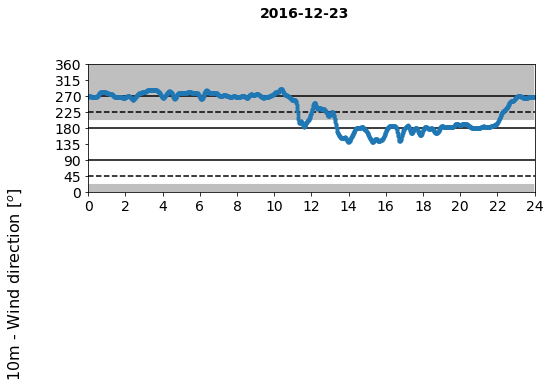

In [26]:
year = '2016'
month = '12'
day = '23'

fig = plt.figure(figsize=(8,8))

fig.text(.0, .5, '10m - Wind direction [$^{o}$]', ha='center', va='center', rotation='vertical', fontsize = 16)

ax1 = fig.add_subplot(311)
ax1.plot(obs_wind_dir_rolling[int(year+month+day)][:,:],'.')
ax1.hlines(270,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(180,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(90,0,obs_wind_dir_rolling[int(year+month+day)].shape[0])
ax1.hlines(45,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')
ax1.hlines(225,0,obs_wind_dir_rolling[int(year+month+day)].shape[0], linestyles='dashed')

ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 202.5, 360,  facecolor='gray', alpha=0.5)
ax1.fill_between(np.arange(obs_wind_dir_rolling[int(year+month+day)].shape[0]), 0, 22.5,  facecolor='gray', alpha=0.5)

ax1.set_xlim([0, obs_wind_dir_rolling[int(year+month+day)].shape[0]-1])
ax1.set_ylim([0, 360])
ax1.set_xticks(np.arange(0,obs_wind_dir_rolling[int(year+month+day)].shape[0]+120,120))    
ax1.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24 ])
ax1.set_yticks(np.arange(0,405,45))
fig.suptitle("%s-%s-%s" %(year,month,day), fontsize=14,fontweight='bold')
ax1.tick_params(labelsize=14)
plt.show()

In [116]:
### create table

col_labels = ['obs [mm]', 'MEPS [mm]','Difference [%]', 'Average diff [%]']
row_labels = ['Nov 2016', 'Dec 2016', 'Jan 2017', 'Feb 2017', 'Mar 2017']
table_vals = [[51.80, 209.98, 94.24, 84.69],
             [51.80, 209.98, 94.24, 84.69],
             [51.80, 209.98, 94.24, 84.69],
             [51.80, 209.98, 94.24, 84.69],
             [51.80, 209.98, 94.24, 84.69]]

In [114]:
table_vals = np.random.random((5,4))
table_vals

array([[0.03018925, 0.61228408, 0.64555577, 0.96731494],
       [0.02472939, 0.18974799, 0.63119363, 0.83444872],
       [0.81210792, 0.87564305, 0.28250644, 0.81339911],
       [0.8906976 , 0.44889255, 0.42241188, 0.16333626],
       [0.16356516, 0.29343181, 0.8777937 , 0.24224646]])

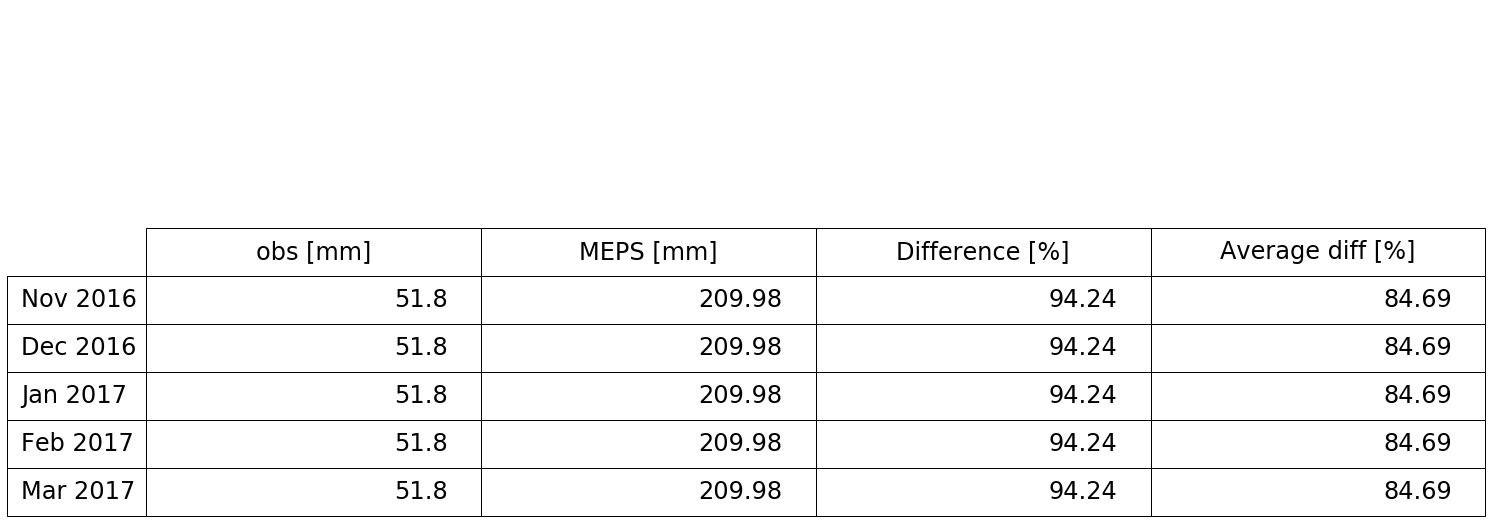

In [117]:
# Draw table
the_table = plt.table(cellText = table_vals,
                     rowLabels = row_labels,
                     colLabels = col_labels,
                #     loc = 'center'
                     )
the_table.auto_set_font_size(False)
the_table.set_fontsize(24)
the_table.scale(4,4)

# Removing ticks and spines enables you to get the figure only with table
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right','top','bottom','left']:
    plt.gca().spines[pos].set_visible(False)